In [1]:
!pip install fsspec

https://stackoverflow.com/questions/45545110/how-do-you-parallelize-apply-on-pandas-dataframes-making-use-of-all-cores-on-o/45545111

In [2]:
!pip install dask distributed --upgrade

Requirement already up-to-date: dask in /opt/conda/lib/python3.6/site-packages (2.8.0)
Requirement already up-to-date: distributed in /opt/conda/lib/python3.6/site-packages (2.8.0)


In [3]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

<Client: 'tcp://127.0.0.1:39059' processes=1 threads=4, memory=2.10 GB>

In [4]:
import time
import pickle
import matplotlib.pyplot as plt
import pandas
print('pandas',pandas.__version__)
import numpy
print('numpy',numpy.__version__)
import dask.dataframe as dd
from dask.multiprocessing import get

pandas 0.23.4
numpy 1.13.3


In [5]:
df = pandas.DataFrame(
    numpy.random.randint(0,1000,size=(1000, 4)), 
    columns=list('ABCD')
    )
print(df.shape)
df.head()

(1000, 4)


A    B    C    D
0  343    7  639  875
1  150   16  889   21
2  307  425  593  463
3  650  951  364  237
4  716  223  493  472

In [6]:
ddata = dd.from_pandas(df, npartitions=4)

In [7]:
def double_col_a(row):
    row_as_dict=dict(row)
    return row_as_dict['A']*2

options for scheduler are 'single-threaded','threads','processes'

The threaded scheduler executes computations with a local `multiprocessing.pool.ThreadPool`.

See https://docs.dask.org/en/latest/scheduling.html

In [8]:
# https://stackoverflow.com/questions/45545110/how-do-you-parallelize-apply-on-pandas-dataframes-making-use-of-all-cores-on-o/45545111
start_time = time.time()
res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='threads')
print(time.time() - start_time)

0.31391382217407227


In [9]:
with open('multiprocessing_data.pkl','rb') as f: 
    serial_reslts, pool_reslts, lambda_reslts = pickle.load(f)

In [10]:
serial_reslts

{100: 0.01564290523529053,
 1000: 0.13357844352722167,
 10000: 1.9118867635726928,
 100000: 12.924072241783142}

In [11]:
pool_reslts

{100: 0.1539085626602173,
 1000: 0.15258731842041015,
 10000: 0.8222435235977172,
 100000: 7.081635594367981}

In [12]:
number_of_tests=10
list_of_row_size=list(pool_reslts.keys())

In [13]:
dask_threads_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        ddata = dd.from_pandas(df, npartitions=4)
        res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='threads')
        test_reslts.append(time.time() - start_time)
    dask_threads_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 0.7676186561584473 for 100
elapsed time: 2.6344821453094482 for 1000
elapsed time: 23.54408288002014 for 10000
elapsed time: 183.82325291633606 for 100000


In [14]:
dask_processes_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        ddata = dd.from_pandas(df, npartitions=4)
        res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='processes')
        test_reslts.append(time.time() - start_time)
    dask_processes_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 2.36395525932312 for 100
elapsed time: 6.512456655502319 for 1000
elapsed time: 18.972564458847046 for 10000
elapsed time: 110.54921293258667 for 100000


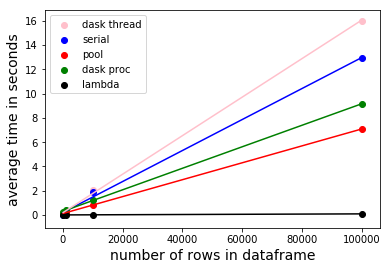

In [15]:
serial_x = list(serial_reslts.keys()) # list_of_row_size
serial_y = list(serial_reslts.values())

pool_x = list(pool_reslts.keys()) # list_of_row_size
pool_y = list(pool_reslts.values())

lambda_x = list(lambda_reslts.keys()) # list_of_row_size
lambda_y = list(lambda_reslts.values())

dask_processes_x = list(dask_processes_reslts.keys()) # list_of_row_size
dask_processes_y = list(dask_processes_reslts.values())

dask_threads_x = list(dask_threads_reslts.keys()) # list_of_row_size
dask_threads_y = list(dask_threads_reslts.values())


_=plt.scatter(dask_threads_x,dask_threads_y,color='pink',label='dask thread')
_=plt.scatter(serial_x,serial_y,color='blue',label='serial')
_=plt.scatter(pool_x,pool_y,color='red',label='pool')
_=plt.scatter(dask_processes_x,dask_processes_y,color='green',label='dask proc')
_=plt.scatter(lambda_x,lambda_y,color='black',label='lambda')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)
_=plt.plot(numpy.unique(serial_x), numpy.poly1d(numpy.polyfit(serial_x, serial_y, 1))(numpy.unique(serial_x)),color='blue') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(pool_x), numpy.poly1d(numpy.polyfit(pool_x, pool_y, 1))(numpy.unique(pool_x)),color='red') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(lambda_x), numpy.poly1d(numpy.polyfit(lambda_x, lambda_y, 1))(numpy.unique(lambda_x)),color='black') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(dask_processes_x), numpy.poly1d(numpy.polyfit(dask_processes_x, dask_processes_y, 1))(numpy.unique(dask_processes_x)),color='green') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(dask_threads_x), numpy.poly1d(numpy.polyfit(dask_threads_x, dask_threads_y, 1))(numpy.unique(dask_threads_x)),color='pink') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

ax = plt.gca()
_=ax.legend()
#ax.grid(True)

Dask vs multiprocessing:
https://github.com/dask/dask/issues/1783

There are additional libraries built on top of Dask,<BR>

https://github.com/jmcarpenter2/swifter
https://github.com/jmcarpenter2/swifter/blob/master/examples/swifter_apply_examples.ipynb
https://github.com/jmcarpenter2/swifter/blob/master/examples/swiftapply_speedcomparison.ipynb

Ignore the rest of these cells

# Dask dashboard
    
https://docs.dask.org/en/latest/diagnostics-distributed.html

In [24]:
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

#client = Client(threads_per_worker=20, n_workers=1)
client

/opt/conda/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: 'tcp://127.0.0.1:33335' processes=1 threads=20, memory=2.10 GB>

see http://localhost:8787/status

(If running in Docker, you'd need to have that port exposed)

# Profiling

https://docs.dask.org/en/latest/diagnostics-local.html

In [25]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler

In [26]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof,CacheProfiler() as cprof:
    res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='processes')

In [27]:
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

bokeh.models.layouts.Column(
    id='32b3aa90-3fe9-4198-9097-9d924d2de98a',
    children=[bokeh.models.tools.ToolbarBox(
         id='9af6fa01-8ba9-4cd5-b159-31500b972ae0',
         css_classes=[],
         disabled=False,
         height=None,
         js_event_callbacks={},
         js_property_callbacks={},
         name=None,
         sizing_mode='fixed',
         subscribed_events=[],
         tags=[],
         toolbar=bokeh.models.tools.ProxyToolbar(
             id='fa9f6e60-e571-415c-a89b-7d51e3ecddfa',
             js_event_callbacks={},
             js_property_callbacks={},
             logo='normal',
             name=None,
             subscribed_events=[],
             tags=[],
             tools=[bokeh.models.tools.HoverTool(
                  id='4600bd71-5ccc-42b3-93bc-97e66650b6e7',
                  anchor='center',
                  attachment='horizontal',
                  callback=None,
                  formatters={},
                  js_event_callbacks={},
                  js_property_callbacks={},
                  line_policy='nearest',
                  mode='mouse',
                  name=None,
                  names=[],
                  point_policy='follow_mouse',
                  renderers='auto',
                  show_arrow=True,
                  subscribed_events=[],
                  tags=[],
                  toggleable=True,
                  tooltips='\n    <div>\n        <span style="font-size: 14px; font-weight: bold;">Key:</span>&nbsp;\n        <span style="font-size: 10px; font-family: Monaco, monospace;">@key</span>\n    </div>\n    <div>\n        <span style="font-size: 14px; font-weight: bold;">Task:</span>&nbsp;\n        <span style="font-size: 10px; font-family: Monaco, monospace;">@function</span>\n    </div>\n    '),
              bokeh.models.tools.SaveTool(
                  id='016667bc-fc5b-4b22-b2a0-cf7556fcf651',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.ResetTool(
                  id='cf37a0a0-297e-45ec-b47f-497f0697ac2f',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.WheelZoomTool(
                  id='f71f0c26-f731-49a9-b691-a19e0751236d',
                  dimensions='width',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  maintain_focus=True,
                  name=None,
                  speed=0.0016666666666666668,
                  subscribed_events=[],
                  tags=[],
                  zoom_on_axis=True),
              bokeh.models.tools.PanTool(
                  id='66abf788-9038-494a-b2b3-0e0f6eb4081d',
                  dimensions='width',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.SaveTool(
                  id='52365f3f-0b51-4e5d-88b4-bd92d7233545',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.ResetTool(
                  id='7a0eccba-2dab-4d64-ace4-3a6fc1e0cdb0',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.WheelZoomTool(
                  id='8ca22011-7efa-4911-9c99-ebae36c13d9d',
                  dimensions='width',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  maintain_focus=True,
     

In [28]:
prof.visualize()

bokeh.plotting.figure.Figure(
    id='72f84acd-fe8f-41da-963a-f338f62f7d65',
    above=[],
    aspect_scale=1,
    background_fill_alpha={'value': 1.0},
    background_fill_color={'value': '#ffffff'},
    below=[bokeh.models.axes.LinearAxis(
         id='a02d90f1-9481-45d6-8ee7-642b929f2a15',
         axis_label='Time (s)',
         axis_label_standoff=5,
         axis_label_text_align='left',
         axis_label_text_alpha={'value': 1.0},
         axis_label_text_baseline='bottom',
         axis_label_text_color={'value': '#444444'},
         axis_label_text_font='helvetica',
         axis_label_text_font_size={'value': '10pt'},
         axis_label_text_font_style='italic',
         axis_label_text_line_height=1.2,
         axis_line_alpha={'value': 1.0},
         axis_line_cap='butt',
         axis_line_color={'value': None},
         axis_line_dash=[],
         axis_line_dash_offset=0,
         axis_line_join='bevel',
         axis_line_width={'value': 1},
         bounds='auto',
         fixed_location=None,
         formatter=bokeh.models.formatters.BasicTickFormatter(
             id='9b3cb5d1-018c-4701-a7d8-6ab43c532c58',
             js_event_callbacks={},
             js_property_callbacks={},
             name=None,
             power_limit_high=5,
             power_limit_low=-3,
             precision='auto',
             subscribed_events=[],
             tags=[],
             use_scientific=True),
         js_event_callbacks={},
         js_property_callbacks={},
         level='overlay',
         major_label_orientation='horizontal',
         major_label_overrides={},
         major_label_standoff=5,
         major_label_text_align='center',
         major_label_text_alpha={'value': 1.0},
         major_label_text_baseline='alphabetic',
         major_label_text_color={'value': '#444444'},
         major_label_text_font='helvetica',
         major_label_text_font_size={'value': '8pt'},
         major_label_text_font_style='normal',
         major_label_text_line_height=1.2,
         major_tick_in=2,
         major_tick_line_alpha={'value': 1.0},
         major_tick_line_cap='butt',
         major_tick_line_color={'value': None},
         major_tick_line_dash=[],
         major_tick_line_dash_offset=0,
         major_tick_line_join='bevel',
         major_tick_line_width={'value': 1},
         major_tick_out=6,
         minor_tick_in=0,
         minor_tick_line_alpha={'value': 1.0},
         minor_tick_line_cap='butt',
         minor_tick_line_color={'value': 'black'},
         minor_tick_line_dash=[],
         minor_tick_line_dash_offset=0,
         minor_tick_line_join='bevel',
         minor_tick_line_width={'value': 1},
         minor_tick_out=4,
         name=None,
         plot=bokeh.plotting.figure.Figure(id='72f84acd-fe8f-41da-963a-f338f62f7d65', ...),
         subscribed_events=[],
         tags=[],
         ticker=bokeh.models.tickers.BasicTicker(
             id='dd6139f5-5d55-49cf-8a3d-61683652fdd3',
             base=10.0,
             desired_num_ticks=6,
             js_event_callbacks={},
             js_property_callbacks={},
             mantissas=[1, 2, 5],
             max_interval=None,
             min_interval=0.0,
             name=None,
             num_minor_ticks=5,
             subscribed_events=[],
             tags=[]),
         visible=True,
         x_range_name='default',
         y_range_name='default')],
    border_fill_alpha={'value': 1.0},
    border_fill_color={'value': '#ffffff'},
    css_classes=[],
    disabled=False,
    extra_x_ranges={},
    extra_y_ranges={},
    h_symmetry=True,
    height=None,
    hidpi=True,
    js_event_callbacks={},
    js_property_callbacks={},
    left=[bokeh.models.axes.CategoricalAxis(
         id='ff45884d-7444-43cb-bb88-121960a9fbd7',
         axis_label='Worker ID',
         axis_label_standoff=5,
         axis_label_text_align='left',
         axis_label_text_alpha={'value': 1.0},
         axis_label_text_baseline='bottom',
         axis_

In [29]:
!pip install graphviz

In [30]:
res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).visualize()

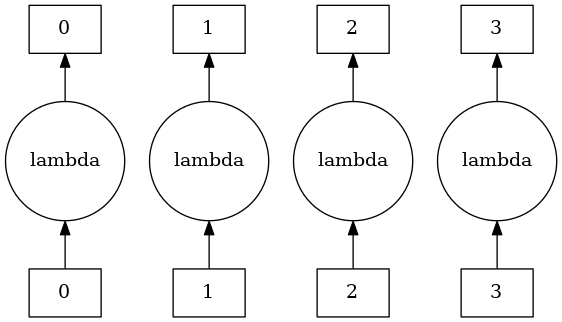

In [31]:
res